In [57]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import AutoTokenizer

# Path to your data
images_folder = "/home/gs285/image_captioning/Images"
captions_file = "/home/gs285/image_captioning/captions.txt"


# Load captions
data = pd.read_csv(captions_file)
data

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [58]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [59]:
import numpy as np
data['train'] = np.random.choice([True,False], size=len(data), p=[0.8,0.2])
data.to_csv('data.csv', index=False)

In [60]:
data = pd.read_csv('data.csv')
data

,image,caption,train
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,True
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,True
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,True
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,True
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,True
...,...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face,True
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .,False
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...,False
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .,True


In [61]:
subset_imageIds = data[data['train']].image.tolist()

subset_imageIds = data[~data['train']].image.tolist()

In [62]:
import os
import shutil

# Ensure the train-images and val-images folders exist
os.makedirs('train_images', exist_ok=True)
os.makedirs('val_images', exist_ok=True)

# Filter training and validation images based on the 'train' column
training_images = data[data['train']]['image']
validation_images = data[~data['train']]['image']

# Copy training images to the train-images folder
train_copied_count = 0
for image_id in training_images:
    src_path = os.path.join(images_folder, image_id)
    dest_path = os.path.join('train_images', image_id)
    if os.path.exists(src_path) and not os.path.exists(dest_path):  # Check if source exists and destination does not
        shutil.copy(src_path, dest_path)
        train_copied_count += 1

# Copy validation images to the val-images folder
val_copied_count = 0
for image_id in validation_images:
    src_path = os.path.join(images_folder, image_id)
    dest_path = os.path.join('val_images', image_id)
    if os.path.exists(src_path) and not os.path.exists(dest_path):  # Check if source exists and destination does not
        shutil.copy(src_path, dest_path)
        val_copied_count += 1

# Print the number of images copied
print(f"Copied {train_copied_count} new images to 'train_images'.")
print(f"Copied {val_copied_count} new images to 'val_images'.")

Copied 0 new images to 'train_images'.
Copied 542 new images to 'val_images'.


In [63]:
from collections import Counter, defaultdict
import re

class Vocabulary:
    def __init__(self, init_token="<start>", eos_token="<end>", pad_token="<pad>", unk_token="<unk>"):
        self.init_token = init_token
        self.eos_token = eos_token
        self.pad_token = pad_token
        self.unk_token = unk_token

        self.word2idx = {}
        self.idx2word = {}
        self.word_counts = Counter()

        # Add special tokens
        self.add_word(self.pad_token)
        self.add_word(self.unk_token)
        self.add_word(self.init_token)
        self.add_word(self.eos_token)

    def add_word(self, word):
        if word not in self.word2idx:
            idx = len(self.word2idx)
            self.word2idx[word] = idx
            self.idx2word[idx] = word

    def build_vocab(self, sentences, min_freq=1):
        """Build the vocabulary from a list of tokenized sentences."""
        self.word_counts.update([word for sentence in sentences for word in sentence])
        for word, count in self.word_counts.items():
            if count >= min_freq:
                self.add_word(word)

    def __len__(self):
        return len(self.word2idx)


# Preprocessing function to tokenize captions
def tokenize(sentence):
    """Simple tokenizer to split sentence into words and lowercase them."""
    return [word.lower() for word in re.findall(r"\b\w+\b", sentence)]


# Sample Usage
all_captions = data[data['train']]['caption'].tolist()  # List of all captions
tokenized_captions = [tokenize(c) for c in all_captions]  # Tokenize each caption

# Build vocabulary
vocab_builder = Vocabulary()
vocab_builder.build_vocab(tokenized_captions, min_freq=5)  # Set minimum frequency as needed




In [64]:
class Vocab:
    pass

vocab = Vocab()

# Insert '<pad>' token at index 0 (already handled by our custom Vocabulary class)
# Build the `itos` (index-to-string) mapping
vocab.itos = list(vocab_builder.idx2word.values())

# Build the `stoi` (string-to-index) mapping
vocab.stoi = defaultdict(lambda: vocab_builder.word2idx.get('<unk>', 0))
for word, idx in vocab_builder.word2idx.items():
    vocab.stoi[word] = idx


In [65]:
import matplotlib.pyplot as plt
import numpy as np

def show(image, title=None, sz=5):
    """Display an image with a title."""
    plt.figure(figsize=(sz, sz))

    # Convert image tensor to numpy array
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).numpy()  # Convert (C, H, W) to (H, W, C)
        image = np.clip(image, 0, 1)  # Ensure values are in range [0, 1] for display

    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()



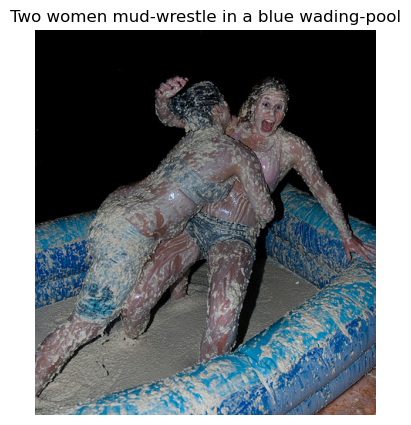

tensor([  2,  45, 700,   1,   6,   4, 122,   1,   3])


In [66]:
import numpy as np
from torchvision import transforms
class CaptioningData(Dataset):
    def __init__(self, root, df, vocab):
        #reset the index and drop the previous index
        self.df = df.reset_index(drop=True)
        self.root = root
        self.vocab = vocab
        self.transform = transforms.Compose([ 
            transforms.Resize(224),
            transforms.RandomCrop(224),
            transforms.RandomHorizontalFlip(), 
            transforms.ToTensor(), 
            transforms.Normalize((0.485, 0.456, 0.406), 
                                 (0.229, 0.224, 0.225))]
        )
    def __getitem__(self, index):
        """Returns one data pair (image and caption)."""
        #get the "index" row of the dataframe
        row = self.df.iloc[index].squeeze()
        #get the image id
        id = row.image
        image_path = f'{self.root}/{id}'
        image = Image.open(os.path.join(image_path)).convert('RGB')

        caption = row.caption
        tokens = str(caption).lower().split()
        target = []
        target.append(vocab.stoi['<start>'])
        target.extend([vocab.stoi[token] for token in tokens])
        target.append(vocab.stoi['<end>'])
        # Convert caption to tensor
        target = torch.Tensor(target).long()
        return image, target, caption
    def choose(self):
        #choose a random image from the dataset for visualization
        return self[np.random.randint(len(self))]
    def __len__(self):
        return len(self.df)
    def collate_fn(self, data):
        # Sort a data list by caption length (descending order).
        data.sort(key=lambda x: len(x[1]), reverse=True)
        
        images, targets, captions = zip(*data)
        images = torch.stack([self.transform(image) for image in images], 0)
        #get the length of each caption
        lengths = [len(tar) for tar in targets]
        #create the target tensor with the longest caption length
        _targets = torch.zeros(len(captions), max(lengths)).long()
        for i, tar in enumerate(targets):
            end = lengths[i]
            _targets[i, :end] = tar[:end] 
        return images.to(device), _targets.to(device), torch.tensor(lengths).long().to(device)
    

trn_ds = CaptioningData('train_images',data[data['train']], vocab)
val_ds = CaptioningData('val_images', data[~data['train']], vocab)

image, target, caption = trn_ds.choose()
show(image, title=caption, sz=5); print(target)

In [67]:
trn_dl = DataLoader(trn_ds, 32, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, 32, collate_fn=val_ds.collate_fn)

# Inspect the contents of the first batch in the DataLoader
batch = next(iter(trn_dl))  # Get the first batch from the DataLoader
images, targets, lengths = batch  # Unpack the batch

# Display batch information
print(f"Images shape: {images.shape}")  # Batch of images
print(f"Targets shape: {targets.shape}")  # Batch of targets (padded captions)
print(f"Lengths: {lengths}")  # Actual lengths of the captions in the batch

Images shape: torch.Size([32, 3, 224, 224])
Targets shape: torch.Size([32, 23])
Lengths: tensor([23, 22, 21, 20, 19, 18, 18, 17, 17, 17, 16, 16, 15, 15, 15, 15, 14, 14,
        14, 14, 14, 14, 13, 12, 12, 12, 11, 11, 11, 10, 10, 10],
       device='cuda:0')


In [68]:
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import models
import torch.nn as nn
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1] # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features
encoder = EncoderCNN(256).to(device)

from torchsummary import summary
print(summary(encoder, input_size=(3, 224, 224)))

/home/gs285/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/gs285/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [69]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=80):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths.cpu(), batch_first=True) 
        outputs, _ = self.lstm(packed)
        outputs = self.linear(outputs[0])
        return outputs
    def predict(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seq_length):
            hiddens, states = self.lstm(inputs, states) # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1)) # outputs: (batch_size, vocab_size)
            _, predicted = outputs.max(1) # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted) # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1) # inputs: (batch_size, 1, embed_size)

        sampled_ids = torch.stack(sampled_ids, 1) # sampled_ids: (batch_size, max_seq_length)
        # convert predicted tokens to strings
        sentences = []
        for sampled_id in sampled_ids:
            sampled_id = sampled_id.cpu().numpy()
            sampled_caption = []
            for word_id in sampled_id:
                word = vocab.itos[word_id]
                sampled_caption.append(word)
                if word == '<end>':
                    break
            sentence = ' '.join(sampled_caption)
            sentences.append(sentence)
        return sentences

In [87]:
def train_batch(data, encoder, decoder, optimizer, criterion):
    encoder.train()
    decoder.train()
    images, captions, lengths = data
    images = images.to(device)
    captions = captions.to(device)
    targets = pack_padded_sequence(captions, lengths.cpu(), batch_first=True)[0]
    features = encoder(images)
    outputs = decoder(features, captions, lengths)
    loss = criterion(outputs, targets)
    decoder.zero_grad()
    encoder.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

In [88]:
@torch.no_grad()
def validate_batch(data, encoder, decoder, criterion):
    encoder.eval()
    decoder.eval()
    images, captions, lengths = data
    images = images.to(device)
    captions = captions.to(device)
    targets = pack_padded_sequence(captions, lengths.cpu(), batch_first=True)[0]
    features = encoder(images)
    outputs = decoder(features, captions, lengths)
    loss = criterion(outputs, targets)
    return loss

In [89]:
class Report:
    def __init__(self, n_epochs):
        self.n_epochs = n_epochs
        self.logs = {"trn_loss": [], "val_loss": []}
        self.epoch_avgs = []

    def record(self, pos, trn_loss=None, val_loss=None, end='\n'):
        """Record losses for training and validation."""
        if trn_loss is not None:
            self.logs["trn_loss"].append(trn_loss)
        if val_loss is not None:
            self.logs["val_loss"].append(val_loss)
        # Use conditional formatting to handle None values
        trn_loss_str = f"{trn_loss:.4f}" if trn_loss is not None else "N/A"
        val_loss_str = f"{val_loss:.4f}" if val_loss is not None else "N/A"
        print(f"Epoch Progress: {pos:.2f} - Training Loss: {trn_loss_str} - Validation Loss: {val_loss_str}", end=end)


    def report_avgs(self, epoch):
        """Report average losses for the epoch."""
        avg_trn_loss = sum(self.logs["trn_loss"][-len(trn_dl):]) / len(trn_dl)
        avg_val_loss = sum(self.logs["val_loss"][-len(val_dl):]) / len(val_dl)
        self.epoch_avgs.append((avg_trn_loss, avg_val_loss))
        print(f"Epoch {epoch}/{self.n_epochs} - "
              f"Avg Training Loss: {avg_trn_loss:.4f} - Avg Validation Loss: {avg_val_loss:.4f}")

def plot_epochs(self, log=True):
    """Plot training and validation losses over epochs."""
    import matplotlib.pyplot as plt

    # Ensure data is transferred to CPU if necessary
    trn_losses, val_losses = zip(*[(t.item() if torch.is_tensor(t) else t, 
                                    v.item() if torch.is_tensor(v) else v) 
                                   for t, v in self.epoch_avgs])
    epochs = range(1, self.n_epochs + 1)

    plt.plot(epochs, trn_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.title('Training and Validation Loss')
    if log:
        plt.yscale('log')  # Optionally use logarithmic scale
    plt.show()


In [90]:
encoder = EncoderCNN(256).to(device)
decoder = DecoderRNN(256, 512, len(vocab.itos), 1).to(device)
criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.AdamW(params, lr=1e-3)
n_epochs = 10
log = Report(n_epochs)

/home/gs285/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/gs285/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [91]:
from PIL import ImageFile
for epoch in range(n_epochs):
    if epoch == 5: optimizer = torch.optim.AdamW(params, lr=1e-4)
    N = len(trn_dl)
    ImageFile.LOAD_TRUNCATED_IMAGES = True
    for i, data in enumerate(trn_dl):
        trn_loss = train_batch(data, encoder, decoder, optimizer, criterion)
        pos = epoch + (1+i)/N
        log.record(pos=pos, trn_loss=trn_loss, end='\r')

    N = len(val_dl)
    for i, data in enumerate(val_dl):
        val_loss = validate_batch(data, encoder, decoder, criterion)
        pos = epoch + (1+i)/N
        log.record(pos=pos, val_loss=val_loss, end='\r')

    log.report_avgs(epoch+1)

# Save the model weights
torch.save(encoder.state_dict(), 'encoder_weights.pth')
torch.save(decoder.state_dict(), 'decoder_weights.pth')


Epoch 1/10 - Avg Training Loss: 3.1720 - Avg Validation Loss: 2.7254
Epoch 2/10 - Avg Training Loss: 2.5741 - Avg Validation Loss: 2.5285
Epoch 3/10 - Avg Training Loss: 2.3383 - Avg Validation Loss: 2.4502
Epoch 4/10 - Avg Training Loss: 2.1533 - Avg Validation Loss: 2.4254
Epoch 5/10 - Avg Training Loss: 1.9896 - Avg Validation Loss: 2.4257
Epoch 6/10 - Avg Training Loss: 1.8197 - Avg Validation Loss: 2.3640
Epoch 7/10 - Avg Training Loss: 1.7553 - Avg Validation Loss: 2.3591
Epoch 8/10 - Avg Training Loss: 1.7199 - Avg Validation Loss: 2.3579
Epoch 9/10 - Avg Training Loss: 1.6906 - Avg Validation Loss: 2.3588
Epoch 10/10 - Avg Training Loss: 1.6640 - Avg Validation Loss: 2.3606


In [75]:
# log.plot_epochs(log=True)

In [77]:
import glob
import random

# Glob: Retrieve all image files in the directory
def Glob(path_pattern):
    """Return all file paths matching the pattern."""
    return glob.glob(f"{path_pattern}/*")

# Choose: Randomly select a file from the list
def choose(files):
    """Randomly choose a file from the list."""
    return random.choice(files)

In [ ]:
# Define encoder and decoder architectures
encoder = EncoderCNN(256).to(device)
decoder = DecoderRNN(256, 512, len(vocab.itos), 1).to(device)


# Load the saved weights
encoder_weights_path = '/home/gs285/image_captioning/encoder_weights.pth'
decoder_weights_path = '/home/gs285/image_captioning/decoder_weights.pth'

encoder.load_state_dict(torch.load(encoder_weights_path))
decoder.load_state_dict(torch.load(decoder_weights_path))


/home/gs285/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/gs285/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

[nltk_data] Downloading package punkt_tab to /home/gs285/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
Evaluating: 100%|██████████| 7854/7854 [07:05<00:00, 18.46image/s]


Average BLEU Score on Validation Set: 0.0738
Predicted Caption: <start> a man in a white shirt and jeans is standing in front of a large metal fan <unk> <end>
Reference Captions: ['A cook steps back as flames leap from a pan in a kitchen .', 'A man in a black shirt and jeans is backing away from a fire on a stove .', 'an Asian man is cooking on dish that is on fire in a commercial style kitchen .', 'A pan on the stove in flames , a cook with an intense expression on his face .', 'A woman at a stove jumps back from the high flames of a pan .']
BLEU Score: 0.1988


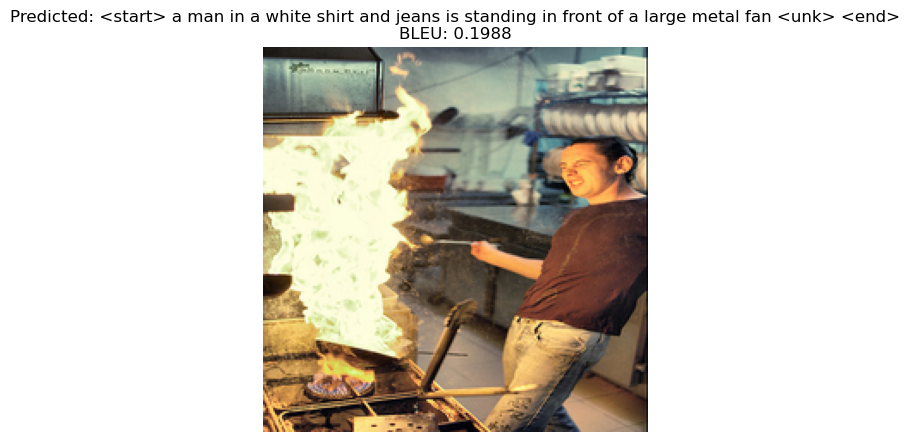

Predicted Caption: <start> a little boy in a red shirt and blue shorts is running on a track <unk> <end>
Reference Captions: ['A boy holds a soccer ball while he stands next to a running track .', 'A boy is outside holding a red and blue soccer ball .', 'a young boy carrying a large soccer ball with a soccer feild in the background', 'A young boy in a green shirt is holding a red and blue soccer ball .', 'There is a young kid , dressed up in a soccer uniform , holding his ball .']
BLEU Score: 0.0659


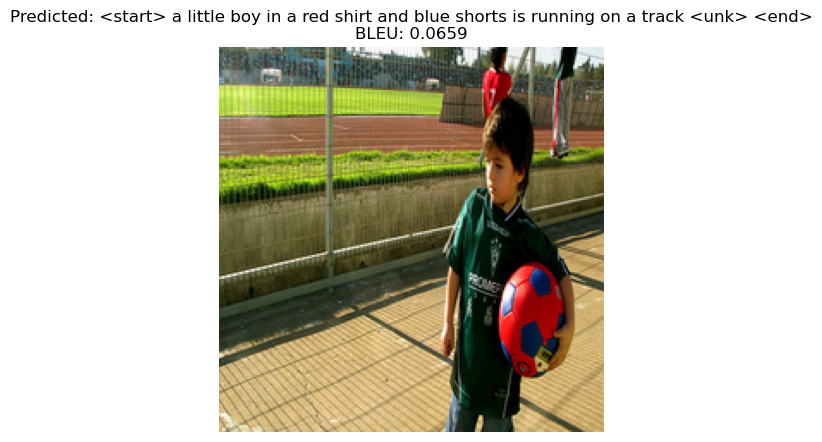

Predicted Caption: <start> a surfer is riding a wave <unk> <end>
Reference Captions: ['a man in a wetsuit is surfing', 'A man surfing in a wave', 'a surfer is riding a wave through green colored ocean water .', 'A surfer rides a big wave across dark green water .', 'The surfer is coming in from riding a big wave .']
BLEU Score: 0.3238


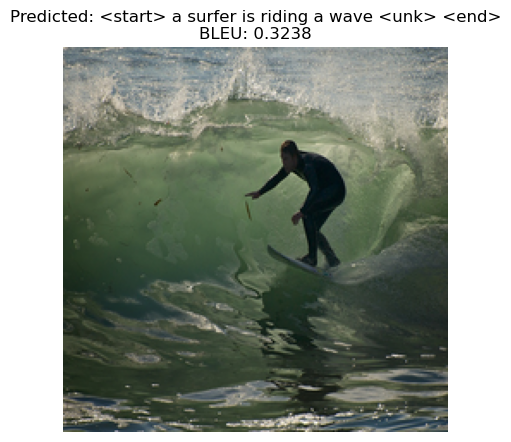

Predicted Caption: <start> a young girl in a pink shirt is jumping off a wooden structure <unk> <end>
Reference Captions: ['a boy in a green shirt is jumping with his arms in the air at the end of a bowling alley .', 'A boy wearing a green shirt is jumping in front of a lane at a bowling alley .', 'A child jumps in the air at a bowling alley .', 'A young boy with a Mohawk and green shirt is excited about bowling .', 'A young boy with a Mohawk jumping at a bowling alley']
BLEU Score: 0.0673


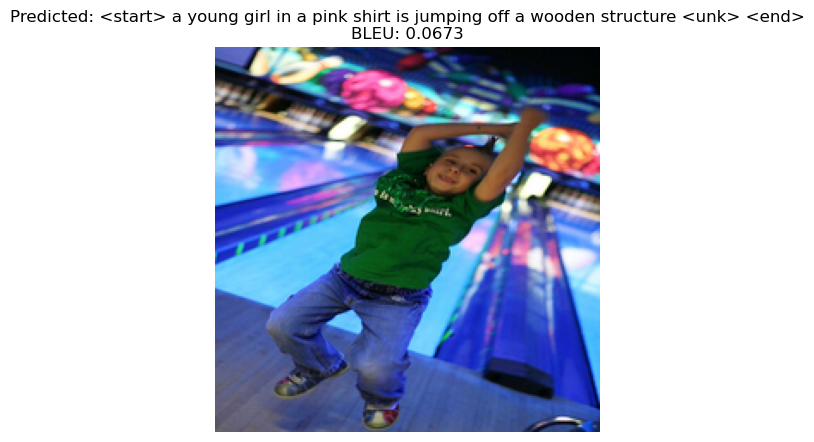

Predicted Caption: <start> a man in a red shirt and helmet riding a bike in a forest <unk> <end>
Reference Captions: ['A dirt biker covered in mud racing', 'A man on a dirt bike is covered in mud .', 'a motorcyclist riding covered head to toe with mud', 'Man in a helmet riding a dirt bike covered with mud .', 'One motorcyclist covered in mud riding his motorcycle through the mud .']
BLEU Score: 0.0758


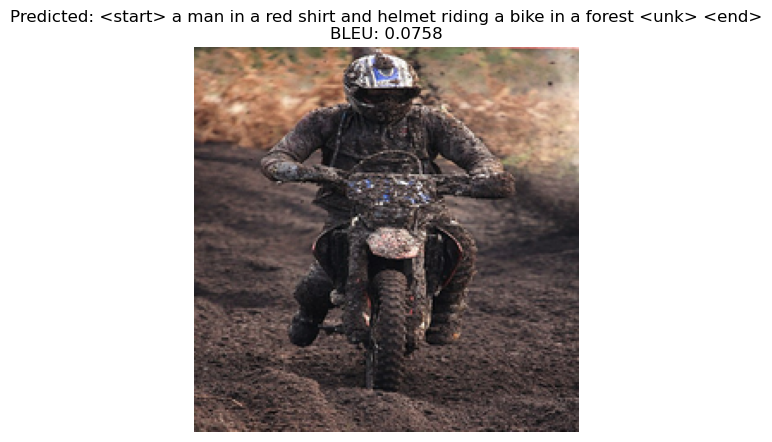

In [93]:
import pandas as pd
import random
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from PIL import Image
from nltk.tokenize import word_tokenize
from tqdm import tqdm

nltk.download('punkt_tab')

def load_image(image_path, transform=None):
    image = Image.open(image_path).convert('RGB')
    image = image.resize([224, 224], Image.LANCZOS)
    if transform is not None:
        tfm_image = transform(image)[None]
    return image, tfm_image


# Step 1: Load Data and Prepare Reference Captions
data = pd.read_csv("data.csv")  # Load the CSV file
#groupby --> list --> dict
references = data.groupby("image")["caption"].apply(list).to_dict()  # Group captions by image
# print(references["1000268201_693b08cb0e.jpg"])

# Step 2: Evaluate the Whole Validation Set
@torch.no_grad()
def evaluate_validation_set(validation_files):
    """
    Evaluate BLEU scores for the entire validation set.
    
    Args:
        validation_files (list): List of validation image paths.
    
    Returns:
        float: Average BLEU score across the validation set.
        list: BLEU scores and captions for visualization.
    """
    smoothing_function = SmoothingFunction().method1
    total_bleu_score = 0
    results = []

    for image_path in tqdm(validation_files, desc="Evaluating", unit="image"):
        image_id = image_path.split("/")[-1]  # Extract the image ID
        reference_captions = references.get(image_id, [])  # Get reference captions for the image
        
        if not reference_captions:
            continue  # Skip if no references are available

        # Predict caption
        transform = transforms.Compose([
            transforms.ToTensor(), 
            transforms.Normalize((0.485, 0.456, 0.406), 
                                 (0.229, 0.224, 0.225))
        ])
        org_image, tfm_image = load_image(image_path, transform)
        image_tensor = tfm_image.to(device)

        encoder.eval()
        decoder.eval()
        feature = encoder(image_tensor)
        
        ########################################
        #why [0]
        predicted_caption = decoder.predict(feature)[0]

        # Compute BLEU score
        reference_tokens = [nltk.word_tokenize(ref.lower()) for ref in reference_captions]
        predicted_tokens = nltk.word_tokenize(predicted_caption.lower())
        bleu_score = sentence_bleu(reference_tokens, predicted_tokens, smoothing_function=smoothing_function)

        total_bleu_score += bleu_score
        results.append((org_image, predicted_caption, reference_captions, bleu_score))

    avg_bleu_score = total_bleu_score / len(validation_files)
    return avg_bleu_score, results

# Step 3: Visualize Random Examples
def visualize_results(results, num_examples=5):
    """
    Visualize a random subset of results with images and captions.
    
    Args:
        results (list): List of tuples containing (image, predicted_caption, reference_captions, BLEU score).
        num_examples (int): Number of examples to visualize.
    """
    sampled_results = random.sample(results, num_examples)
    
    for org_image, predicted_caption, reference_captions, bleu_score in sampled_results:
        print(f"Predicted Caption: {predicted_caption}")
        print(f"Reference Captions: {reference_captions}")
        print(f"BLEU Score: {bleu_score:.4f}")
        show(org_image, title=f"Predicted: {predicted_caption}\nBLEU: {bleu_score:.4f}")

# Step 4: Evaluate and Visualize
validation_files = Glob("val_images")  # Get validation image paths
avg_bleu, results = evaluate_validation_set(validation_files)
print(f"Average BLEU Score on Validation Set: {avg_bleu:.4f}")

visualize_results(results)
